### The lowercase dataset refers to a modified version of the dataset where certain changes have been made. E.g, the attribute 'latinName' has been changed to 'latin name' to ensure lowercase formatting."

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
!pip install sentencepiece
!pip install transformers
!pip install timm

In [4]:
import gc
import pandas as pd
import numpy as np
import os
import torch
import glob
import pathlib
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
import math
warnings.filterwarnings('ignore')
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
nltk.download('punkt')

root_data = '/content/drive/MyDrive/webNLG/PROJECT/Data/'
root = '/content/drive/MyDrive/webNLG/PROJECT/modified/'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
if torch.cuda.is_available():
   dev = torch.device("cuda:0")
   print("Running on the GPU")
else:
   dev = torch.device("cpu")
   print("Running on the CPU")

Running on the GPU


## **Loading Datasets**

In [6]:
lowercase_train_data = pd.read_csv(root +'new_train.csv') #dataset with space included and also converted to lowercase
lowercase_dev_data = pd.read_csv(root + 'dev/new_dev.csv')

In [7]:
lowercase_train_data = lowercase_train_data.iloc[:4500,:]
lowercase_train_data = lowercase_train_data.sample(frac=1)
batch_size = 8
numOfBatches = math.floor(len(lowercase_train_data)/batch_size)

In [8]:
%%capture
Tokenizer = T5Tokenizer.from_pretrained('t5-base')
Model = T5ForConditionalGeneration.from_pretrained('t5-base',
                                             return_dict=True)
Model.to(dev)

###**Loading the Optimiser**

In [9]:
Optimizer = Adafactor(
    Model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

In [10]:
from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        
            {value}
        
    """.format(loss=loss,value=value, max=max))

In [11]:
num_of_epochs=10

### **Train the Model**

In [12]:
#Sets the module in training mode
Model.train()

loss_per_10steps=[]
for epoch in range(1, num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))
  
  runningLoss = 0

  out = display(progress(1, numOfBatches+1), display_id=True)
  for i in range(numOfBatches):

    inputbatch = []
    labelbatch = []
    new_data= lowercase_train_data[i*batch_size:i*batch_size+batch_size]
    for index,row in new_data.iterrows():
      input = row['input_text']+'</s>' 
      labels = row['target_text']+'</s>'    
      inputbatch.append(input)
      labelbatch.append(labels)
    inputbatch = Tokenizer.batch_encode_plus(inputbatch,truncation=True,padding=True,return_tensors ='pt')["input_ids"]
    labelbatch = Tokenizer.batch_encode_plus(labelbatch,truncation=True,padding=True,return_tensors ="pt") ["input_ids"]
    inputbatch = inputbatch.to(dev)
    labelbatch = labelbatch.to(dev)

    # clear out the gradients of all Variables 
    Optimizer.zero_grad()

    # Forward propogation
    outputs = Model(input_ids=inputbatch, labels=labelbatch)
    loss = outputs.loss
    loss_num = loss.item()
    logits = outputs.logits
    runningLoss += loss_num
    if i%10 == 0:      
      loss_per_10steps.append(loss_num)
    out.update(progress(loss_num,i, numOfBatches+1))

    # calculating the gradients
    loss.backward()

    #updating the params
    Optimizer.step()

  running_loss = runningLoss/int(numOfBatches)
  print('Epoch: {} , Running loss: {}'.format(epoch,runningLoss))
  

Running epoch: 1


Epoch: 1 , Running loss: 109.60151781141758
Running epoch: 2


Epoch: 2 , Running loss: 69.87114477157593
Running epoch: 3


Epoch: 3 , Running loss: 56.22110628336668
Running epoch: 4


Epoch: 4 , Running loss: 48.432977974414825
Running epoch: 5


Epoch: 5 , Running loss: 42.00171983987093
Running epoch: 6


Epoch: 6 , Running loss: 36.85188189893961
Running epoch: 7


Epoch: 7 , Running loss: 32.93150479346514
Running epoch: 8


Epoch: 8 , Running loss: 29.857982099056244
Running epoch: 9


Epoch: 9 , Running loss: 26.50297461822629
Running epoch: 10


Epoch: 10 , Running loss: 24.367724085226655


### Plotting For Loss

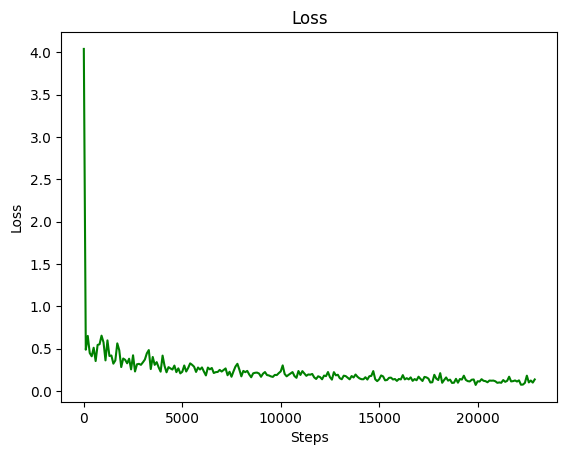

In [13]:
# Plotting the loss
steps = [i*100 for i in range(len(loss_per_10steps))] 
plt.plot(steps, loss_per_10steps, color='green')  # Set the color to red
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

### Testing the Model

In [14]:
Model.eval()
input_ids = Tokenizer.encode("Russia | leader | Putin", return_tensors="pt")  # Batch size 1
input_ids = input_ids.to(dev)
outputs = Model.generate(input_ids)
Tokenizer.decode(outputs[0], skip_special_tokens=True)     

'["Putin is Russia\'s leader.", "The leader of Russia is'

In [15]:
def make_prediction(model, text):

   Model.eval()
   input_ids = Tokenizer.encode(text, return_tensors="pt").to(dev)  # Batch size 1
   s = time.time()
   outputs = Model.generate(input_ids)
   gen_text = Tokenizer.decode(outputs[0], skip_special_tokens=True)
   elapsed = time.time() - s
   print('Generated in {} seconds'.format(str(elapsed)[:4]))
   return gen_text

make_prediction(Model, 'Russia | leader | Putin')

Generated in 0.30 seconds


'["Putin is Russia\'s leader.", "The leader of Russia is'

### Evaluating the Model

In [16]:
%%capture
#geting the inputs (input_text) from the dataset
lowercase_dev_data_inputs = [ x.replace('[','').replace(']','') for x in lowercase_dev_data['input_text'].values.tolist() ]

#feeding the input into the model and getting the predictions
lowercase_dev_data_pred = [ make_prediction(Model, x) for x in lowercase_dev_data_inputs ]

#loading the reference values from the target_text column
lowercase_dev_data_ref = [ x.replace('[','').replace(']','') for x in lowercase_dev_data['target_text'].values.tolist() ]

In [35]:
#lowercase_dev_data_ref

In [17]:
import os
import locale
locale.getpreferredencoding = lambda: "UTF-8"

file_path_ref = 'lowercase_dev_reference.txt'
file_path_hypo = 'lowercase_dev_hypothesis.txt'

# Create or overwrite the files
with open(file_path_ref, 'w', encoding='utf-8') as f:
    for row in lowercase_dev_data_ref:
        f.write(row + '\n')

with open(file_path_hypo, 'w', encoding='utf-8') as f:
    for row in lowercase_dev_data_pred:
        f.write(row + '\n')

In [18]:
!pip install meteor pyter3 bert_score razdel tabulate sacrebleu -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 13.9 MB/s eta 0:00:00


In [19]:
lowercase_data_eval = !python {root_data}eval.py -hyp lowercase_dev_hypothesis.txt -ref lowercase_dev_reference.txt -nr 1 -m bleu,meteor,bert,chrf++,ter -lng en

In [22]:
lowercase_data_eval_df = lowercase_data_eval[-3:]
lowercase_data_eval_df
#lowercas_result = pd.DataFrame(lowercase_data_eval_df)
#lowercas_result
#result.to_csv(root + 'result.csv', index=False)

['   BLEU    METEOR    chrF++    TER    BERT-SCORE P    BERT-SCORE R    BERT-SCORE F1',
 '-------  --------  --------  -----  --------------  --------------  ---------------',
 '13.3711        -1      0.32   0.77            0.89            0.89             0.89']